# Twitter Sentiment Analysis Using Natural Language Processing
#### Authors: Allison Gao, Meaghan Ross, Raylin Soriano

October, 2021

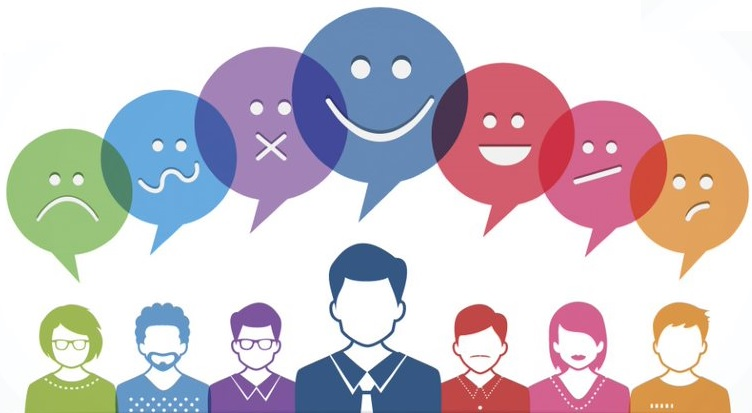


In [188]:
conda install -c conda-forge xgboost

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [189]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
import nltk
import random
from os import path
from PIL import Image
from nltk import word_tokenize, pos_tag
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, TweetTokenizer, word_tokenize
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, \
classification_report, accuracy_score, precision_score, plot_confusion_matrix

## Loaded Data and Exploratory Data Analysis (EDA)

In [191]:
df = pd.read_csv("/Users/allisongao/Dropbox/Flatiron/Phase 4/NLP_project/NLP Data.csv", encoding='latin1')

In [192]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [193]:
df.shape

(9093, 3)

#### Imbalanced Target Variable

Majority of the predictive class is associated with the "no emotion" category while "I can't tell" only accounts for 156 observations (1.7%) of the entire dataset. 

In [194]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [195]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

#### Renaming the following columns' names for easier reference 

In [196]:
df['target']=df['is_there_an_emotion_directed_at_a_brand_or_product']
df.drop('is_there_an_emotion_directed_at_a_brand_or_product',axis=1, inplace=True)

#same for the tweet_text column
df['text']=df['tweet_text']
df.drop('tweet_text',axis=1, inplace=True)

#### Generating a new column specifying the number of characters in each Tweet

In [197]:
df['length']= df['text'].str.len()

#### Drop Duplicates

In [198]:
df.duplicated().sum()

22

In [199]:
df.drop_duplicates(inplace=True)

In [200]:
df.shape

(9071, 4)

#### Drop columns that contain an empty Tweet

In [201]:
df.dropna(subset=['text'], inplace=True)

In [202]:
df.target.value_counts()

No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: target, dtype: int64

In [203]:
df.text.isna().sum()

0

## More EDA - Visualizations

#### What is the distribution of the emotion of tweets?

Majority of the tweets are categorized as those with no emotion with a much smaller portion being coded as having negative emotion.

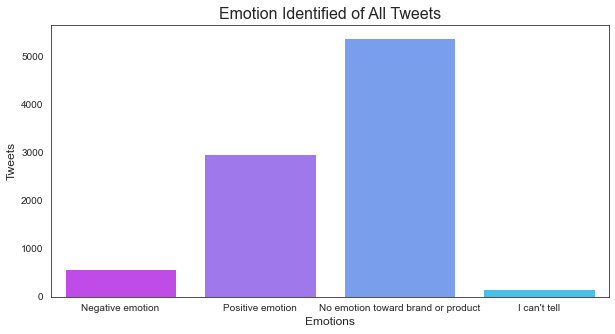

In [204]:
plt.figure(figsize = (10,5))
sns.set_style("white")
all_count_viz = sns.countplot(x=df['target'], palette='cool_r')
all_count_viz.set_title('Emotion Identified of All Tweets',fontsize = 16)
all_count_viz.set_xlabel('Emotions',fontsize = 12)
all_count_viz.set_ylabel('Tweets',fontsize = 12)
plt.show()


#### For the purpose of our analysis, we dropped "I can't tell" from our predictive class due to small sample size

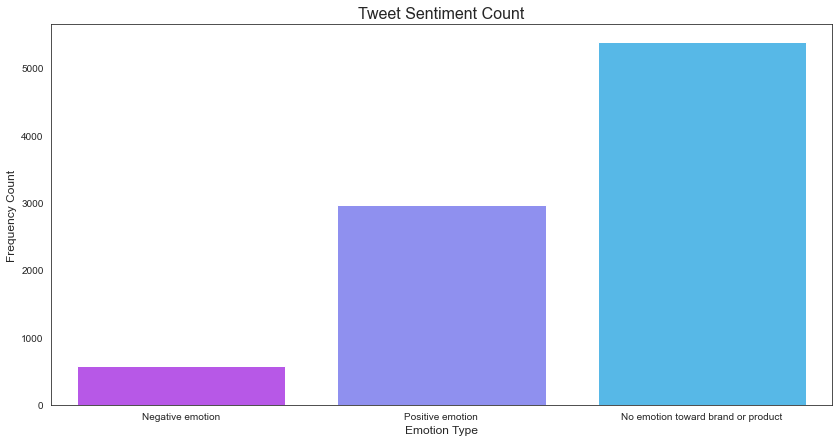

In [205]:
df_for_graph = df.loc[df["target"] != "I can't tell"]

plt.figure(figsize = (14,7))
graph_emotion_type = sns.countplot(x="target", palette="cool_r", data=df_for_graph)
graph_emotion_type.set_title("Tweet Sentiment Count", fontsize = 16)
graph_emotion_type.set_xlabel("Emotion Type", fontsize = 12)
graph_emotion_type.set_ylabel("Frequency Count", fontsize = 12);

#### What is the distribution of tweets by company?

While not the focus of modeling, it's helpful to know the breakdown of tweets by company. There is a large amount of undetermined, which matches up with the data description that says the tweets were only marked with a product or brand if there was a positive or negative emotion identified. The number of undetermined matches the number of tweets classified as No emotion or I can't tell

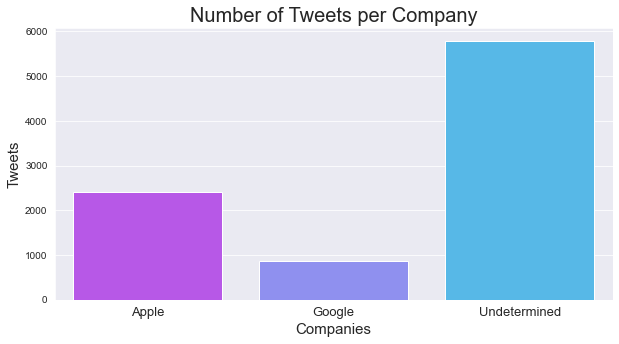

In [206]:
apple_products = ('iPhone', 'iPad or iPhone App', 'iPad','Apple','Other Apple product or service')
google_products = ('Google','Android','Android App','Other Google product or service')
def brand(x):
    if x in apple_products:
        return 'Apple'
    if x in google_products:
        return 'Google'
    else:
        return 'Undetermined'
df['brand'] = df['emotion_in_tweet_is_directed_at'].apply(brand)

# Plot resulting counts of tweet targets
plt.figure(figsize = (10,5))
sns.set_style("darkgrid")
brand_viz = sns.countplot(x=df['brand'], palette = 'cool_r')
brand_viz.set_title('Number of Tweets per Company',fontsize = 20)
brand_viz.set_xlabel('Companies',fontsize = 15)
brand_viz.set_ylabel('Tweets',fontsize = 15)
brand_viz.set_xticklabels(['Apple','Google', 'Undetermined'],fontsize = 13)
plt.show()

#### What is the distribution of tweets by tweet length?

Also not the focus of modeling, but it is also helpful to know the breakdown of tweets by their length. The shortest Tweet has 11 characters while the longest Tweet has 178 characters. The tweet length skews slightly left indicating that overall tweets tend to have more characters.

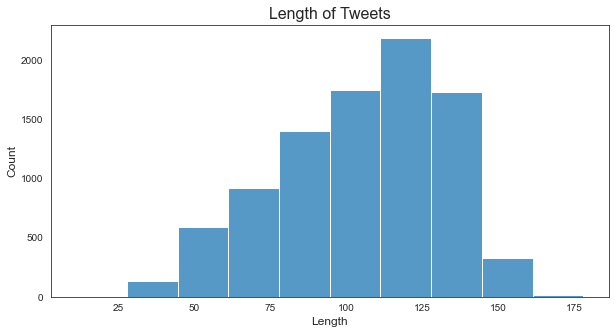

In [207]:
plt.figure(figsize = (10,5))
sns.set_style("white")
brand_viz = sns.histplot(df['length'], bins=10)
brand_viz.set_title('Length of Tweets',fontsize = 16)
brand_viz.set_xlabel('Length',fontsize = 12)
brand_viz.set_ylabel('Count',fontsize = 12)
plt.show()
#fig.savefig('images/length_of_tweet_hist.png');

In [208]:
length_data = df.loc[(df["target"] == "Positive emotion")|(df["target"] == "Negative emotion")]

In [209]:
length_data.head()

,emotion_in_tweet_is_directed_at,target,text,length,brand
0,iPhone,Negative emotion,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",127.0,Apple
1,iPad or iPhone App,Positive emotion,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",139.0,Apple
2,iPad,Positive emotion,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,79.0,Apple
3,iPad or iPhone App,Negative emotion,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,82.0,Apple
4,Google,Positive emotion,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",131.0,Google


#### What is the distribution of tweets by tweet length for the negative and positive emotion groups?

Negative emotion is a small portion of the count frequency relative to positive emotion. In terms of distribution, they are similar.


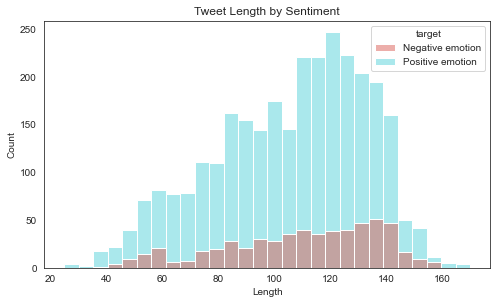

In [210]:
length_data = df.loc[(df["target"] == "Positive emotion")|(df["target"] == "Negative emotion")]
f = plt.figure(figsize=(8,10))
ax = f.add_subplot(2,1,1)

sns.histplot(data=length_data, ax=ax, stat='count', multiple="layer",
             x="length", kde=False,
             palette="hls", hue="target",
             element="bars", legend=True)
ax.set_title("Tweet Length by Sentiment")
ax.set_xlabel("Length")
ax.set_ylabel("Count");

# Word Cloud

Since this dataset's Tweets came from the South by Southwest event, several words like #SXSW and iPad appeared in all three emotion groups in the target variable. As a result, we wanted to pull the unique words from the positive and negative emotion groups for exploratory analysis. On the positive side, we see words like congratulations, preparation, and pixel. On the negative side, we have words like newbie and mindstorm. 

In [211]:
regex_token = RegexpTokenizer(r"\w+")

new_pos_text = df['text'].loc[df['target'] == 'Positive emotion'].tolist()
new_pos_text = ' '.join(new_pos_text).lower()
new_pos_text = regex_token.tokenize(new_pos_text)


new_neg_text = df['text'].loc[df['target'] == 'Negative emotion'].tolist()
new_neg_text = ' '.join(new_neg_text).lower()
new_neg_text = regex_token.tokenize(new_neg_text)


new_neut_text = df['text'].loc[df['target'] == 'No emotion toward brand or product'].tolist()
new_neut_text = ' '.join(new_neut_text).lower()
new_neut_text = regex_token.tokenize(new_neut_text)

unique_neg = set(new_neg_text)
unique_pos = set(new_pos_text)
unique_neut = set(new_neut_text)


only_pos= unique_pos.difference(unique_neut.union(unique_neg))
only_pos = ' '.join(only_pos)

only_neg= unique_neg.difference(unique_pos.union(unique_neut))
only_neg = ' '.join(only_neg)

only_neut= unique_neut.difference(unique_pos.union(unique_neg))
only_neut = ' '.join(only_neut)

### Positive emotion word cloud 

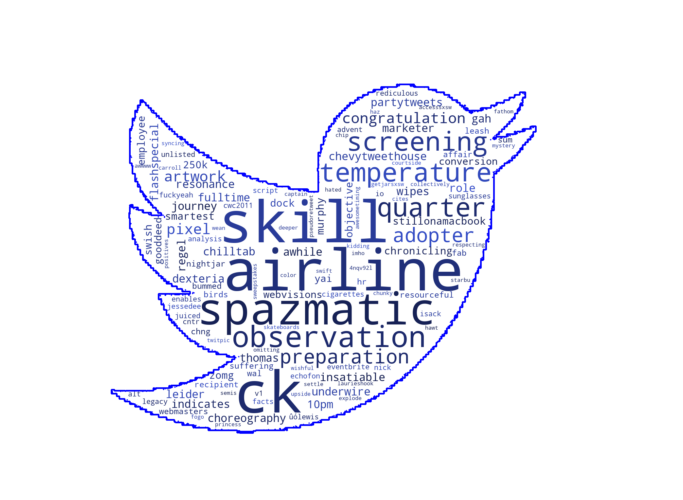

In [212]:
def blue_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 230
    s = int(100.0 * 150.0 / 255.0)
    l = int(100.0 * float(random_state.randint(50, 130)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(path.join(d, "twitter_logo2.png")))

wc = WordCloud(max_font_size=175, 
               mask=mask, 
               background_color = 'white',
               max_words=125,
               contour_width=5, 
               contour_color='blue',
               color_func = blue_color_func).generate(only_pos)


plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


### Negative emotion word cloud 

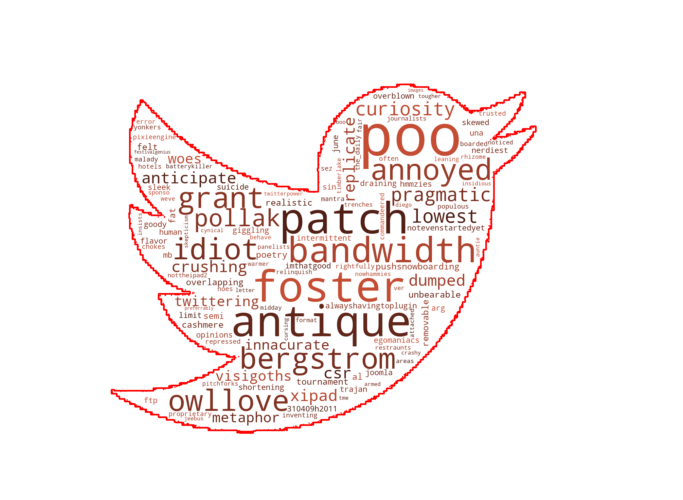

In [213]:
def red_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 10
    s = int(100.0 * 150.0 / 255.0)
    l = int(100.0 * float(random_state.randint(50, 130)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(path.join(d, "twitter_logo2.png")))

wc = WordCloud(max_font_size=175, 
               mask=mask, 
               background_color = 'white',
               max_words=125,
               contour_width=5, 
               contour_color='red',
               color_func=red_color_func).generate(only_neg)


plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### No emotion word cloud 

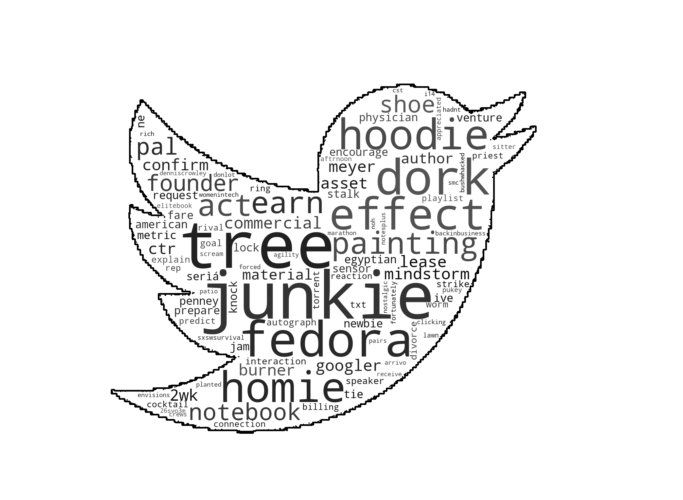

In [215]:
def grey_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 0
    s = int(100.0 * 0.0 / 255.0)
    l = int(100.0 * float(random_state.randint(10, 90)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(path.join(d, "twitter_logo2.png")))

wc = WordCloud(max_font_size=200, 
               mask=mask, 
               background_color = 'white',
               max_words=100,
               contour_width=5, 
               contour_color='black',
               color_func=grey_color_func).generate(only_neut)


plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Preparing the Tweets

Processing the Tweets for analysis by using Tweet Tokenizer, lemmatization, and removing stop words.

In [216]:
sw = stopwords.words('english')

In [217]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [218]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the review corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    tweet_token = TweetTokenizer()
    doc = tweet_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
#     stemmer = PorterStemmer() 
#     doc = [stemmer.stem(word) for word in doc]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [219]:
df['tokenized'] = df['text'].apply(doc_preparer)

In [220]:
df.sample(3)

,emotion_in_tweet_is_directed_at,target,text,length,brand,tokenized
3006,NaN,No emotion toward brand or product,Gary Vaynerchuck lÌ_gger ner winelibrary.tv och slÌ_pper i stÌ_llet Iphone-appen Daily Grape. #thankyoueconomy #sxsw #swesxsw,125.0,Undetermined,gary vaynerchuck lì_gger ner winelibrary.tv och slì_pper stì_llet iphone-appen daily grape . #thankyoueconomy #sxsw #swesxsw
5009,NaN,No emotion toward brand or product,"urThots.com Announces Android Promotion Available to First 25,000 New Users .... {link} #SXSW #SXSWI",101.0,Undetermined,"urthots.com announces android promotion available first 25,000 new user ... { link } #sxsw #sxswi"
4055,NaN,No emotion toward brand or product,no umbrella when you have &quot;the list&quot; via @mention ÷¼ Are you all set? ÷_ {link} ÷_ #edchat #musedchat #sxsw #sxswi #newTwitter,139.0,Undetermined,"umbrella "" list "" via @mention  ÷ ¼ set ?  ÷ _ { link }  ÷ _ #edchat #musedchat #sxsw #sxswi #newtwitter"


In [221]:
pd.set_option('display.max_colwidth', None)
df[['target','text', 'tokenized']].head(5)

,target,text,tokenized
0,Negative emotion,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",". @wesley83 3g iphone . 3 hr tweet #rise_austin , dead ! need upgrade . plugin station #sxsw ."
1,Positive emotion,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW","@jessedee know @fludapp ? awesome ipad / iphone app likely appreciate design . also , they're give free t #sxsw"
2,Positive emotion,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,@swonderlin wait #ipad 2 also . sale #sxsw .
3,Negative emotion,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,@sxsw hope year's festival crashy year's iphone app . #sxsw
4,Positive emotion,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)","@sxtxstate great stuff fri #sxsw : marissa mayer ( google ) , tim o'reilly ( tech book / conference ) & matt mullenweg ( wordpress )"


# Modeling 

## Train-Test Split

In [223]:
X = df['tokenized']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state=42,
                                                    stratify=y)

### Data Cleaning

Dropped 'I can't tell' after merging X_train with y_train and X_test with y_test together. 
We then used Label Encode to change the target to numerical data.

In [227]:
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)

In [228]:
y_train.value_counts()

No emotion toward brand or product    4031
Positive emotion                      2227
Negative emotion                       427
I can't tell                           117
Name: target, dtype: int64

In [229]:
df_train.head()

,tokenized,target
2769,want one ! ! rumor : apple open temporary store downtown austin #sxsw ipad 2 launch { link },Positive emotion
2787,#aapl already big winner #sxsw { link } #in,No emotion toward brand or product
7021,@mention google's disavowal plan launch #sxsw .,No emotion toward brand or product
4882,anyone go buy new ipad donate #japan #tsunami victim instead . #sxsw,I can't tell
715,{ link } part presentation #sxsw good thing crash instead . work best iphone / android,Positive emotion


#### Created a pipeline to clean the dataframe

In [230]:
def drop_unidentified(df):
    '''
    Drop rows from DataFrame where the target is 'I can't tell'.
    '''
    df.drop(df.loc[df['target']=="I can't tell"].index, inplace=True)
    return df


def label(df):
    '''
    Encode values of the target to numerical data.
    '''
    df['target'] = df['target'].map({'No emotion toward brand or product': 0,
                                     'Negative emotion': 1,
                                     'Positive emotion': 2})
    return df


cleaning_pipeline = Pipeline(steps=[
    ('drop', FunctionTransformer(drop_unidentified)),
    ('label', FunctionTransformer(label))
])

In [231]:
df_train_clean = cleaning_pipeline.fit_transform(df_train)
df_test_clean = cleaning_pipeline.transform(df_test)

In [232]:
df_test_clean.head()

,tokenized,target
5039,rt @mention : aron pilhofer new york time endorsed html ipad #newsapps #sxsw ask u tweet ...,0
643,"ok nerd , totally bateman . want sign ipad 2 ? #sxsw",0
4451,"podcast social business summit 2011 austin { link } @mention @mention #sxsw , listen new iphone ... delight !",2
177,#winning picture #android #google #sxsw { link },2
4980,team android sxsw  ûò full party detail reveal ! { link } #sxsw,2


In [233]:
df_train_clean.target.value_counts()

0    4031
2    2227
1     427
Name: target, dtype: int64

# Running Models

#### Created a function to print out cross validation scores

In [236]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate on given feature and multiclass target arrays using given pipeline, 
    printing the scoring results for both training and cross_val.
    '''
    scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
    
    results = cross_validate(pipe, X, 
                                   y, 
                                   return_train_score=True, scoring=scoring)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print(results['test_accuracy'])
    print('Cross_Val Accuracy', results['test_accuracy'].mean())
    print('##############')
    print('Training Macro Precision:', results['train_precision_macro'].mean())
    print('Cross_Val Macro Precision:', results['test_precision_macro'].mean())
    print('##############')
    print('Training Macro Recall:', results['train_recall_macro'].mean())
    print('Cross_Val Macro Recall:', results['test_recall_macro'].mean())
    print('##############')
    print('Training Macro F1:', results['train_f1_macro'].mean())
    print('Cross_Val Macro F1:', results['test_f1_macro'].mean())

#### Created a function to print out the confusion matrix

In [237]:
display_labels = ['No Emotion', 
                  'Negative Emotion', 
                  'Positive Emotion']

def print_cm_with_labels(y_true, 
                         y_pred, 
                         display_labels):
    '''
    Takes the true values and predicted values of a classifier and 
    plots a confusion matrix (normalized by predictions) using 
    a list of given display labels.
    '''
    cm = confusion_matrix(y_true, y_pred, normalize = 'pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    ax.grid(False)
    disp.ax_.set_xticklabels(display_labels,rotation=45);

### First Simple Model - baseline model 

In this simple model, we used count vectorizer to simply transform the Tweets into a vector on the basis of the frequency of each word that occurs in the entire text. 

In [242]:
fsm_pipe = Pipeline([('cv', CountVectorizer(stop_words=sw)),
                     ('mnb', MultinomialNB())])

fsm_pipe.fit(df_train_clean['tokenized'], 
             df_train_clean['target'])

Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mnb', MultinomialNB())])

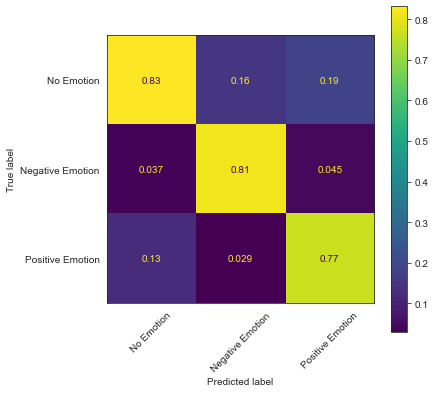

In [243]:
print_cm_with_labels(df_train_clean['target'],
                     fsm_pipe.predict(df_train_clean['tokenized']),
                     display_labels)

In [244]:
print_cv_scores(fsm_pipe, 
                df_train_clean['tokenized'], 
                df_train_clean['target'])

[0.82217651 0.81563201 0.82722513 0.82255049 0.82311144]
Training Accuracy 0.8221391174270755
##############
[0.66866118 0.65893792 0.66791324 0.6828721  0.63575168]
Cross_Val Accuracy 0.66282722513089
##############
Training Macro Precision: 0.8319477343586023
Cross_Val Macro Precision: 0.624752249389291
##############
Training Macro Recall: 0.6870324121417147
Cross_Val Macro Recall: 0.4773316799275314
##############
Training Macro F1: 0.730537232079965
Cross_Val Macro F1: 0.49500203651448704


#### ^ The baseline model gave us a 66% accuracy score and a macro precision of 62%.  Looking at the macro precision between the training and cross validation set, we see a 21% difference. We aim to close this gap to reduce overfitting. 

# Multinomial Bayes

Building off the baseling model, we switched to use Tf-idf Vectorizer to assign each term in the Tweets a weight based on its term frequency (tf) and inverse document frequency (idf).

In [245]:
bayes_pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw,
                                                 max_features=None)),
                       ('mnb', MultinomialNB())])
bayes_pipe.fit(df_train_clean['tokenized'], 
               df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('mnb', MultinomialNB())])

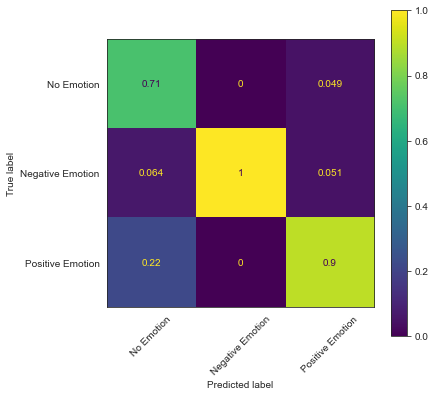

In [246]:
print_cm_with_labels(df_train_clean['target'],
                     bayes_pipe.predict(df_train_clean['tokenized']),
                     display_labels)

In [247]:
print_cv_scores(bayes_pipe, 
                df_train_clean['tokenized'], 
                df_train_clean['target'])

[0.74887809 0.74719521 0.74177263 0.74139865 0.75560957]
Training Accuracy 0.7469708302169036
##############
[0.64173523 0.64323111 0.65968586 0.64697083 0.64023934]
Cross_Val Accuracy 0.6463724756918474
##############
Training Macro Precision: 0.8749007797057823
Cross_Val Macro Precision: 0.5431798691245141
##############
Training Macro Recall: 0.486564820098749
Cross_Val Macro Recall: 0.3895321614972795
##############
Training Macro F1: 0.49147096493798886
Cross_Val Macro F1: 0.36510809009723344


#### ^ This model gave us a 65% accuracy score and a macro precision of 54%.  Looking at the macro precision between the training and cross validation set, we see a 33% difference. Macro precision went down compared to that of the baseline model. 

In [119]:
len(bayes_pipe[0].vocabulary_)

7274

# Random Forest 

In [248]:
RF_pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=sw)),
                     ('rf', RandomForestClassifier(class_weight="balanced"))
])


RF_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('rf', RandomForestClassifier(class_weight='balanced'))])

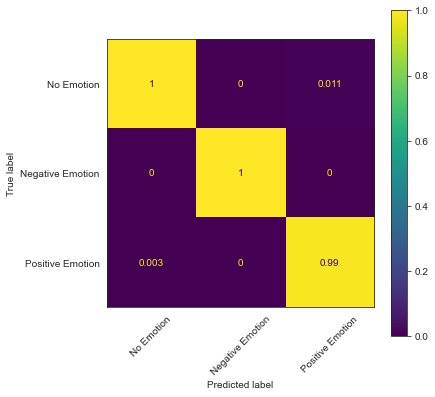

In [249]:
print_cm_with_labels(df_train_clean['target'],
                     RF_pipe.predict(df_train_clean['tokenized']),
                     display_labels)

In [126]:
print_cv_scores(RF_pipe, df_train_clean['tokenized'], df_train_clean['target'])

[0.99513837 0.99626028 0.99626028 0.9960733  0.99551234]
Training Accuracy 0.9958489154824234
##############
[0.66940912 0.6551982  0.68735976 0.67913239 0.66492147]
Cross_Val Accuracy 0.6712041884816754
##############
Training Macro Precision: 0.9965567672336805
Cross_Val Macro Precision: 0.6828099400190621
##############
Training Macro Recall: 0.9970019959688508
Cross_Val Macro Recall: 0.4732985093852468
##############
Training Macro F1: 0.9967780695732398
Cross_Val Macro F1: 0.49857614787462434


#### ^ Random Forest gave us a 67% accuracy score and a macro precision of 68%.  Looking at the macro precision between the training and cross validation set, we see a 31% difference. 

### Using GridSearch on Random Forest to find the best parameters

In [250]:
grid = {
        "tfidf__max_features" : [5000, None],
    
        "rf__n_estimators": [25, 50, 100], 
        
        "rf__max_depth" : [10, 15, 20], 
        
        "rf__min_samples_leaf" : [1, 2, 3]
       
       
       }

gridsearch = GridSearchCV(RF_pipe, grid, return_train_score=True, scoring='precision_macro',verbose=2) 

gridsearch.fit(df_train_clean['tokenized'], df_train_clean['target'])

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25, tfidf__max_features=5000; total time=   0.2s
[CV] END rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25, tfidf__max_features=5000; total time=   0.1s
[CV] END rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25, tfidf__max_features=5000; total time=   0.2s
[CV] END rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25, tfidf__max_features=5000; total time=   0.1s
[CV] END rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25, tfidf__max_features=5000; total time=   0.2s
[CV] END rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25, tfidf__max_features=None; total time=   0.2s
[CV] END rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25, tfidf__max_features=None; total time=   0.2s
[CV] END rf__max_depth=10, rf__min_samples_leaf=1, rf__n_estimators=25, tfidf__max_features=None; total time=   0.2s
[C

[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=50, tfidf__max_features=5000; total time=   0.2s
[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=50, tfidf__max_features=5000; total time=   0.3s
[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=50, tfidf__max_features=5000; total time=   0.3s
[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=50, tfidf__max_features=5000; total time=   0.2s
[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=50, tfidf__max_features=5000; total time=   0.3s
[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=50, tfidf__max_features=None; total time=   0.3s
[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=50, tfidf__max_features=None; total time=   0.3s
[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimators=50, tfidf__max_features=None; total time=   0.4s
[CV] END rf__max_depth=10, rf__min_samples_leaf=3, rf__n_estimat

[CV] END rf__max_depth=15, rf__min_samples_leaf=2, rf__n_estimators=100, tfidf__max_features=5000; total time=   0.5s
[CV] END rf__max_depth=15, rf__min_samples_leaf=2, rf__n_estimators=100, tfidf__max_features=5000; total time=   0.5s
[CV] END rf__max_depth=15, rf__min_samples_leaf=2, rf__n_estimators=100, tfidf__max_features=5000; total time=   0.9s
[CV] END rf__max_depth=15, rf__min_samples_leaf=2, rf__n_estimators=100, tfidf__max_features=5000; total time=   0.9s
[CV] END rf__max_depth=15, rf__min_samples_leaf=2, rf__n_estimators=100, tfidf__max_features=5000; total time=   0.9s
[CV] END rf__max_depth=15, rf__min_samples_leaf=2, rf__n_estimators=100, tfidf__max_features=None; total time=   1.0s
[CV] END rf__max_depth=15, rf__min_samples_leaf=2, rf__n_estimators=100, tfidf__max_features=None; total time=   0.7s
[CV] END rf__max_depth=15, rf__min_samples_leaf=2, rf__n_estimators=100, tfidf__max_features=None; total time=   0.7s
[CV] END rf__max_depth=15, rf__min_samples_leaf=2, rf__n

[CV] END rf__max_depth=20, rf__min_samples_leaf=2, rf__n_estimators=25, tfidf__max_features=5000; total time=   0.3s
[CV] END rf__max_depth=20, rf__min_samples_leaf=2, rf__n_estimators=25, tfidf__max_features=5000; total time=   0.3s
[CV] END rf__max_depth=20, rf__min_samples_leaf=2, rf__n_estimators=25, tfidf__max_features=5000; total time=   0.3s
[CV] END rf__max_depth=20, rf__min_samples_leaf=2, rf__n_estimators=25, tfidf__max_features=5000; total time=   0.3s
[CV] END rf__max_depth=20, rf__min_samples_leaf=2, rf__n_estimators=25, tfidf__max_features=5000; total time=   0.3s
[CV] END rf__max_depth=20, rf__min_samples_leaf=2, rf__n_estimators=25, tfidf__max_features=None; total time=   0.3s
[CV] END rf__max_depth=20, rf__min_samples_leaf=2, rf__n_estimators=25, tfidf__max_features=None; total time=   0.3s
[CV] END rf__max_depth=20, rf__min_samples_leaf=2, rf__n_estimators=25, tfidf__max_features=None; total time=   0.3s
[CV] END rf__max_depth=20, rf__min_samples_leaf=2, rf__n_estimat

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                    

In [177]:
pd.DataFrame(gridsearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__n_estimators,param_tfidf__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.208678,0.008911,0.067741,0.006138,10,1,25,5000,"{'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 25, 'tfidf__max_features': 5000}",0.452419,0.442913,0.468982,0.454771,0.010772,50,0.555918,0.541266,0.574328,0.557171,0.013527
1,0.206348,0.048845,0.056985,0.015750,10,1,25,None,"{'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 25, 'tfidf__max_features': None}",0.440419,0.441342,0.460167,0.447309,0.009100,54,0.534000,0.544884,0.565936,0.548273,0.013256
2,0.311719,0.026357,0.070379,0.003792,10,1,50,5000,"{'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 50, 'tfidf__max_features': 5000}",0.462677,0.450056,0.471128,0.461287,0.008658,43,0.567790,0.557177,0.609522,0.578163,0.022593
3,0.278417,0.006910,0.067979,0.005825,10,1,50,None,"{'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 50, 'tfidf__max_features': None}",0.470325,0.466740,0.472033,0.469700,0.002206,30,0.577434,0.588264,0.578031,0.581243,0.004970
4,0.447132,0.023004,0.068912,0.002286,10,1,100,5000,"{'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100, 'tfidf__max_features': 5000}",0.473510,0.460697,0.477784,0.470664,0.007260,28,0.603042,0.578061,0.585689,0.588931,0.010453
5,0.436018,0.016035,0.074555,0.001560,10,1,100,None,"{'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100, 'tfidf__max_features': None}",0.470315,0.455875,0.476024,0.467405,0.008479,33,0.575312,0.592246,0.582819,0.583459,0.006928
6,0.268310,0.065945,0.089954,0.029205,10,2,25,5000,"{'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 25, 'tfidf__max_features': 5000}",0.452917,0.451884,0.456128,0.453643,0.001807,51,0.507647,0.515857,0.505710,0.509738,0.004399
7,0.187334,0.010063,0.055153,0.003602,10,2,25,None,"{'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 25, 'tfidf__max_features': None}",0.439014,0.447777,0.459091,0.448628,0.008218,53,0.503622,0.505127,0.510282,0.506344,0.002852
8,0.277089,0.016824,0.076008,0.005070,10,2,50,5000,"{'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 50, 'tfidf__max_features': 5000}",0.459047,0.466419,0.473899,0.466455,0.006063,36,0.534879,0.540568,0.538409,0.537952,0.002345
9,0.265198,0.012700,0.069304,0.005119,10,2,50,None,"{'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 50, 'tfidf__max_features': None}",0.467785,0.450719,0.456612,0.458372,0.007078,47,0.535281,0.528626,0.524311,0.529406,0.004512


In [251]:
print('gridsearch best parameters: {}'.format(gridsearch.best_params_))
print('gridsearch best score: {}'.format(gridsearch.best_score_))

gridsearch best parameters: {'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100, 'tfidf__max_features': 5000}
gridsearch best score: 0.5122041980148797


#### ^ Macro Precision is at 51%, which is lower than the model right before this one. 

In [252]:
from sklearn.model_selection import GridSearchCV

grid = {
        "tfidf__max_df" : [0.9, 0.95, 0.98],
        
        "tfidf__min_df" : [0.1, 0.05, 0.15],
    
        "tfidf__ngram_range" : [(1,1), (1,2)],
       
        "tfidf__max_features" : [5000, None]
       
       }

gridsearch = GridSearchCV(RF_pipe, grid, return_train_score=True, scoring='precision_macro',verbose=2) 

gridsearch.fit(df_train_clean['tokenized'], df_train_clean['target'])

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=0.1, tfidf__ngram_range=(1, 1); total time=   1.2s
[CV] END tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=0.1, tfidf__ngram_range=(1, 1); total time=   1.2s
[CV] END tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=0.1, tfidf__ngram_range=(1, 1); total time=   1.2s
[CV] END tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=0.1, tfidf__ngram_range=(1, 1); total time=   1.4s
[CV] END tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=0.1, tfidf__ngram_range=(1, 1); total time=   1.3s
[CV] END tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2); total time=   1.4s
[CV] END tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2); total time=   1.4s
[CV] END tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2); total

[CV] END tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2); total time=   1.8s
[CV] END tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=0.1, tfidf__ngram_range=(1, 2); total time=   2.2s
[CV] END tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=0.05, tfidf__ngram_range=(1, 1); total time=   2.8s
[CV] END tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=0.05, tfidf__ngram_range=(1, 1); total time=   2.9s
[CV] END tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=0.05, tfidf__ngram_range=(1, 1); total time=   2.5s
[CV] END tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=0.05, tfidf__ngram_range=(1, 1); total time=   2.7s
[CV] END tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=0.05, tfidf__ngram_range=(1, 1); total time=   3.2s
[CV] END tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2); total time=   5.2s
[CV] END tfidf__max_df=0.95, tfidf

[CV] END tfidf__max_df=0.98, tfidf__max_features=5000, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2); total time=   2.5s
[CV] END tfidf__max_df=0.98, tfidf__max_features=5000, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2); total time=   2.3s
[CV] END tfidf__max_df=0.98, tfidf__max_features=5000, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2); total time=   2.5s
[CV] END tfidf__max_df=0.98, tfidf__max_features=5000, tfidf__min_df=0.05, tfidf__ngram_range=(1, 2); total time=   2.2s
[CV] END tfidf__max_df=0.98, tfidf__max_features=5000, tfidf__min_df=0.15, tfidf__ngram_range=(1, 1); total time=   1.0s
[CV] END tfidf__max_df=0.98, tfidf__max_features=5000, tfidf__min_df=0.15, tfidf__ngram_range=(1, 1); total time=   1.2s
[CV] END tfidf__max_df=0.98, tfidf__max_features=5000, tfidf__min_df=0.15, tfidf__ngram_range=(1, 1); total time=   1.0s
[CV] END tfidf__max_df=0.98, tfidf__max_features=5000, tfidf__min_df=0.15, tfidf__ngram_range=(1, 1); total time=   1.1s
[CV] END tfidf__max_df=0.98, tfi

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                    

In [253]:
print('gridsearch best parameters: {}'.format(gridsearch.best_params_))
print('gridsearch best score: {}'.format(gridsearch.best_score_))

gridsearch best parameters: {'tfidf__max_df': 0.9, 'tfidf__max_features': 5000, 'tfidf__min_df': 0.15, 'tfidf__ngram_range': (1, 1)}
gridsearch best score: 0.4259731850665448


#### ^ Macro Precision is at 43%, which is the lowest of the Random Forest models ran.

# Logistic Regression

In [254]:
log_pipe= Pipeline([('cv', CountVectorizer(stop_words=sw)),
                    ('log', LogisticRegression(max_iter=100000))
                     
                    ])

log_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

Pipeline(steps=[('cv',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('log', LogisticRegression(max_iter=100000))])

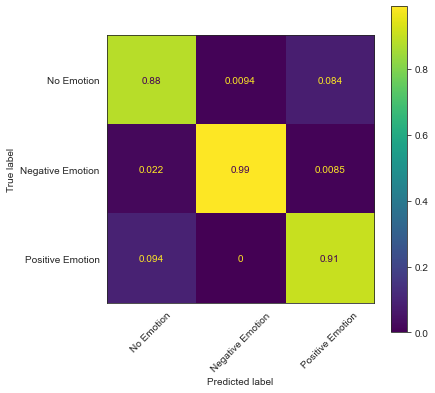

In [255]:
print_cm_with_labels(df_train_clean['target'],
                     log_pipe.predict(df_train_clean['tokenized']),
                     display_labels)

In [256]:
print_cv_scores(log_pipe, df_train_clean['tokenized'], df_train_clean['target'])

[0.90818998 0.90482423 0.90875093 0.9038893  0.91136874]
Training Accuracy 0.9074046372475693
##############
[0.67314884 0.69184742 0.68735976 0.68960359 0.65968586]
Cross_Val Accuracy 0.6803290949887808
##############
Training Macro Precision: 0.9337854027636908
Cross_Val Macro Precision: 0.6114535410051228
##############
Training Macro Recall: 0.8528391392707203
Cross_Val Macro Recall: 0.5241529916392077
##############
Training Macro F1: 0.8873440973189719
Cross_Val Macro F1: 0.5490598256807359


#### ^ Logistc Regression gave us a 68% accuracy score and a macro precision of 61%.  Looking at the macro precision between the training and cross validation set, we see a 32% difference. 

### Using GridSearch on Logistic Regression to find the best parameters

In [257]:
grid = {'log__class_weight': [None, 'balanced'], 
         'log__tol': [0.0001, 0.01, 0.1],
         'log__C' : [0.0001,0.001,0.01],
         'log__penalty': ['l2','none']
        }

In [258]:
gridsearch = GridSearchCV(log_pipe, grid, return_train_score=True, scoring='precision_macro',verbose=2)

gridsearch.fit(df_train_clean['tokenized'], df_train_clean['target'])

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END log__C=0.0001, log__class_weight=None, log__penalty=l2, log__tol=0.0001; total time=   0.3s
[CV] END log__C=0.0001, log__class_weight=None, log__penalty=l2, log__tol=0.0001; total time=   0.2s
[CV] END log__C=0.0001, log__class_weight=None, log__penalty=l2, log__tol=0.0001; total time=   0.2s
[CV] END log__C=0.0001, log__class_weight=None, log__penalty=l2, log__tol=0.0001; total time=   0.2s
[CV] END log__C=0.0001, log__class_weight=None, log__penalty=l2, log__tol=0.0001; total time=   0.2s
[CV] END log__C=0.0001, log__class_weight=None, log__penalty=l2, log__tol=0.01; total time=   0.2s
[CV] END log__C=0.0001, log__class_weight=None, log__penalty=l2, log__tol=0.01; total time=   0.2s
[CV] END log__C=0.0001, log__class_weight=None, log__penalty=l2, log__tol=0.01; total time=   0.2s
[CV] END log__C=0.0001, log__class_weight=None, log__penalty=l2, log__tol=0.01; total time=   0.2s
[CV] END log__C=0.0001, log__class_we

[CV] END log__C=0.001, log__class_weight=None, log__penalty=none, log__tol=0.01; total time=  10.9s
[CV] END log__C=0.001, log__class_weight=None, log__penalty=none, log__tol=0.01; total time=  12.6s
[CV] END log__C=0.001, log__class_weight=None, log__penalty=none, log__tol=0.01; total time=  12.5s
[CV] END log__C=0.001, log__class_weight=None, log__penalty=none, log__tol=0.01; total time=  13.5s
[CV] END log__C=0.001, log__class_weight=None, log__penalty=none, log__tol=0.1; total time=   4.5s
[CV] END log__C=0.001, log__class_weight=None, log__penalty=none, log__tol=0.1; total time=   4.1s
[CV] END log__C=0.001, log__class_weight=None, log__penalty=none, log__tol=0.1; total time=   3.2s
[CV] END log__C=0.001, log__class_weight=None, log__penalty=none, log__tol=0.1; total time=   3.4s
[CV] END log__C=0.001, log__class_weight=None, log__penalty=none, log__tol=0.1; total time=   5.0s
[CV] END log__C=0.001, log__class_weight=balanced, log__penalty=l2, log__tol=0.0001; total time=   0.2s
[

[CV] END log__C=0.01, log__class_weight=balanced, log__penalty=l2, log__tol=0.1; total time=   4.0s
[CV] END log__C=0.01, log__class_weight=balanced, log__penalty=l2, log__tol=0.1; total time=   3.9s
[CV] END log__C=0.01, log__class_weight=balanced, log__penalty=none, log__tol=0.0001; total time= 7.5min
[CV] END log__C=0.01, log__class_weight=balanced, log__penalty=none, log__tol=0.0001; total time= 4.1min
[CV] END log__C=0.01, log__class_weight=balanced, log__penalty=none, log__tol=0.0001; total time= 8.7min
[CV] END log__C=0.01, log__class_weight=balanced, log__penalty=none, log__tol=0.0001; total time= 6.7min
[CV] END log__C=0.01, log__class_weight=balanced, log__penalty=none, log__tol=0.0001; total time=11.3min
[CV] END log__C=0.01, log__class_weight=balanced, log__penalty=none, log__tol=0.01; total time= 2.4min
[CV] END log__C=0.01, log__class_weight=balanced, log__penalty=none, log__tol=0.01; total time= 1.5min
[CV] END log__C=0.01, log__class_weight=balanced, log__penalty=none, 

GridSearchCV(estimator=Pipeline(steps=[('cv',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                       

In [182]:
print('gridsearch best parameters: {}'.format(gridsearch.best_params_))
print('gridsearch best score: {}'.format(gridsearch.best_score_))

gridsearch best parameters: {'log__C': 0.0001, 'log__class_weight': None, 'log__penalty': 'none', 'log__tol': 0.01}
gridsearch best score: 0.5366052039279477


#### ^ Macro Precision is at 54%, which is the better than Random Forest, but still not ideal.

# XGBoost 

In [260]:
xgb_pipe = imbpipe(steps=[('tfidf', TfidfVectorizer(stop_words=sw)),
                          ('sm', SMOTE(random_state=42)),
                          ('xgb', XGBClassifier(random_state=42,
                                                max_depth = 16,
                                                n_jobs = -1))])
xgb_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

[20:40:53] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('sm', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=0.5,...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth

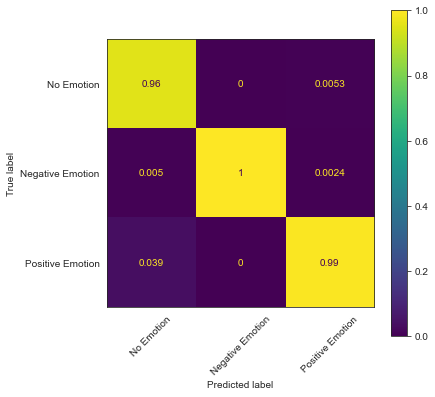

In [261]:
print_cm_with_labels(df_train_clean['target'],
                     xgb_pipe.predict(df_train_clean['tokenized']),
                     display_labels)

In [262]:
print_cv_scores(xgb_pipe, df_train_clean['tokenized'], df_train_clean['target'])

[20:45:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:48:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

#### ^ XGBoost gave us a 67% accuracy score and a macro precision of ~60%.  Looking at the macro precision between the training and cross validation set, we see a 39% difference. 

### Using GridSearch on XGBoost to find the best parameters

In [266]:
grid = [{'tfidf__max_features': [5000, None],
               'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)]}]

gridsearch = GridSearchCV(xgb_pipe, grid, return_train_score=True, scoring='precision_macro',verbose=2)


gridsearch.fit(df_train_clean['tokenized'], df_train_clean['target'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[21:18:24] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=  17.2s
[21:18:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=  19.9s
[21:19:02] WARNING: /opt/concourse/worker/volumes/live

[CV] END tfidf__max_features=None, tfidf__ngram_range=(1, 1); total time=  21.8s
[21:24:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END tfidf__max_features=None, tfidf__ngram_range=(1, 1); total time=  23.1s
[21:25:07] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END tfidf__max_features=None, tfidf__ngram_range=(1, 2); total time=  43.3s
[21:25:51] WARNING: /opt/concours

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                    

In [267]:
print('gridsearch best parameters: {}'.format(gridsearch.best_params_))
print('gridsearch best score: {}'.format(gridsearch.best_score_))

gridsearch best parameters: {'tfidf__max_features': None, 'tfidf__ngram_range': (1, 2)}
gridsearch best score: 0.6206061098382625


#### ^ Macro Precision is at 62%

#### All of the models so far has accuracy and macro precision scores 

# MultinomialNB with Tf-idf and SMOTE

In [134]:
strategy = {0:4031, 1:585, 2:2227}
# strategy = 'SpreadSubsample'
bayes_smote_pipe = imbpipe([
                            ('tfidf', TfidfVectorizer(stop_words=sw)),
                            ('smote', SMOTE(random_state=42,
                                            sampling_strategy=strategy)),
                            ('mnb', MultinomialNB())
])
bayes_smote_pipe.fit(df_train_clean['tokenized'], df_train_clean['target'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('smote',
                 SMOTE(random_state=42,
                       sampling_strategy={0: 4031, 1: 585, 2: 2227})),
                ('mnb', MultinomialNB())])

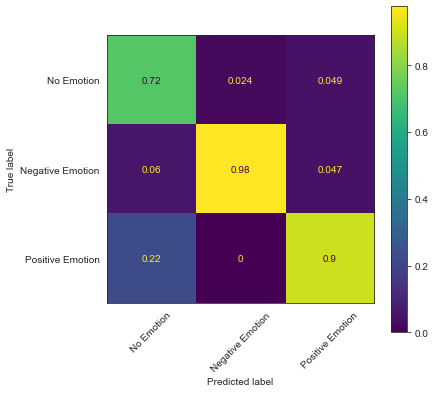

In [270]:
print_cm_with_labels(df_train_clean['target'],
                     bayes_smote_pipe.predict(df_train_clean['tokenized']),
                     display_labels)

In [269]:
print_cv_scores(bayes_smote_pipe, 
                df_train_clean['tokenized'], 
                df_train_clean['target'])

[0.77056844 0.77075542 0.76869858 0.76477188 0.77486911]
Training Accuracy 0.7699326851159312
##############
[0.64622289 0.65370232 0.66043381 0.66791324 0.65295438]
Cross_Val Accuracy 0.656245325355273
##############
Training Macro Precision: 0.8716826134165849
Cross_Val Macro Precision: 0.7618411958281806
##############
Training Macro Recall: 0.5416112313456684
Cross_Val Macro Recall: 0.4179628880009876
##############
Training Macro F1: 0.5761128257145837
Cross_Val Macro F1: 0.4158996108152572


#### ^ This model gave us a 66% accuracy score and a macro precision of 76%.  Looking at the macro precision between the training and cross validation set, we see a 11% difference. This is the smallest difference we've seen so far. 

# Final Model Evaluation with SMOTE
The model that performs the best on macro precision with 76% on the cross validation scores used Multinomial Bayes after putting the data through a TF-IDF vectorizer and using SMOTE to slightly oversample the negative emotion class. We will now see how this model performs on the unseen data of the testing set.

In [135]:
bayes_smote_pipe.score(df_test_clean['tokenized'], df_test_clean['target'])

0.6599371915657245

In [136]:
y_true = df_test_clean['target']
y_pred = bayes_smote_pipe.predict(df_test_clean['tokenized'])

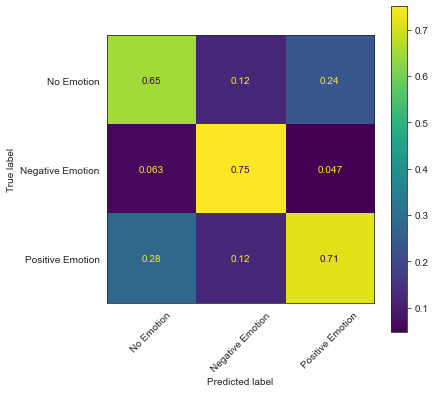

In [137]:
print_cm_with_labels(df_test_clean['target'],
                     bayes_smote_pipe.predict(df_test_clean['tokenized']),
                     display_labels)

In [138]:
precision_score(y_true, y_pred, average='macro')

0.7057536842663273

The model performance drops slightly on the unseen data to 70% on the macro precision score. As you can see from this confusion matrix above, if you look at the columns of the normalized predictions by class, the final model does the best job at predicting the negative emotion tweets even when that was the smallest proportion of the data. However, the model struggles to correctly predict tweets with no emotion as you can see that only 65% of the tweets predicted to be no emotion actually match the original human coding.